# House Sales in King County, USA - TensorFlow Regression - Kaggle

## Reading in the data

I will be making use of the data found in the following Kaggle dataset: https://www.kaggle.com/harlfoxem/housesalesprediction

Importing the libraries that I will be making use of:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Since I am using Jupyter Notebook and I would like to see plots displayed directly below the code cells that produce them, I must use the following:

In [4]:
%matplotlib inline

<br>

In [5]:
df = pd.read_csv('kc_house_data.csv')

The data contains information on over 21,000 houses sold in the King County area between May 2014 and May 2015. I will split this data into a training set and a test set. The training set will be used to train a neural network and the test set will be used to test this neural network. I will be predicting a price for each house in the test set and comparing it to the actual value in order to evaluate my model.

In [6]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

Descriptions for the columns can be seen below:

## Feature Columns

id - Unique ID for each home sold

date - Date of the home sale

price - Price of each home sold

bedrooms - Number of bedrooms

bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower

sqft_living - Square footage of the apartments interior living space

sqft_lot - Square footage of the land space

floors - Number of floors

waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not

view - An index from 0 to 4 of how good the view of the property was

condition - An index from 1 to 5 on the condition of the apartment,

grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an 
average level of construction and design, and 11-13 have a high quality level of construction and design.

sqft_above - The square footage of the interior housing space that is above ground level

sqft_basement - The square footage of the interior housing space that is below ground level

yr_built - The year the house was initially built

yr_renovated - The year of the house’s last renovation

zipcode - What zipcode area the house is in

lat - Lattitude

long - Longitude

sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors

sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

## Data visualisation

### This section is just to explore the data and gain some preliminary insight. You can skip to the feature engineering section if you don't want to view this.


In [7]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

There appear to be no null values which means we won't have to do any cleaning. We will do some feature engineering later on.

Let's look at the correlation between the 'price' column and other columns:

In [8]:
df.corr()['price'].sort_values()

zipcode         -0.053402
id              -0.016772
long             0.022036
condition        0.036056
yr_built         0.053953
sqft_lot15       0.082845
sqft_lot         0.089876
yr_renovated     0.126424
floors           0.256804
waterfront       0.266398
lat              0.306692
bedrooms         0.308787
sqft_basement    0.323799
view             0.397370
bathrooms        0.525906
sqft_living15    0.585241
sqft_above       0.605368
grade            0.667951
sqft_living      0.701917
price            1.000000
Name: price, dtype: float64

As you would expect, square footage of the house, grade and number of bathrooms and bedroom have some correlation with the price of the house.

C:\Users\Pritesh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='bedrooms', ylabel='count'>

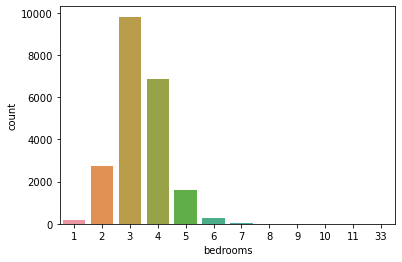

In [9]:
sns.countplot(df['bedrooms'])

<AxesSubplot:xlabel='price', ylabel='sqft_living'>

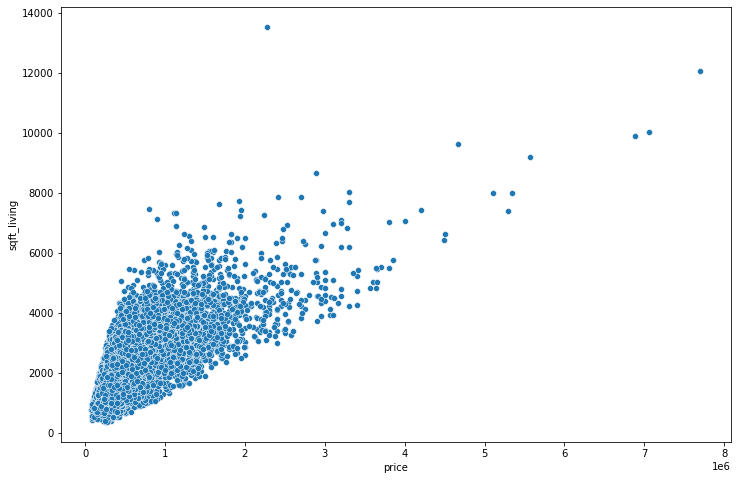

In [10]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='price',y='sqft_living',data=df)

The above figure shows a very strong linear relationship between sqft_living and price.

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

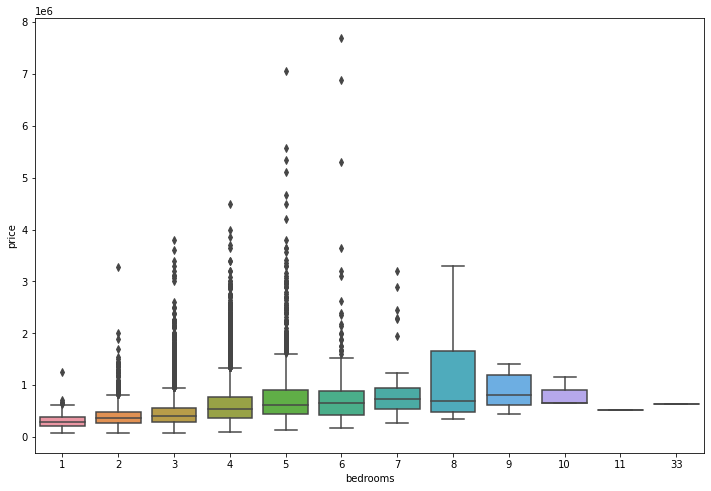

In [11]:
plt.figure(figsize=(12,8))
sns.boxplot(x='bedrooms',y='price',data=df)

The above plot shows the distribution of prices of houses per number of bedrooms. We know from earlier that most of the houses have between 3 and 7 bedrooms so it makes sense that the prices have a large variety for these.

Let's take a look at the distribution of house prices.

<AxesSubplot:xlabel='price', ylabel='Count'>

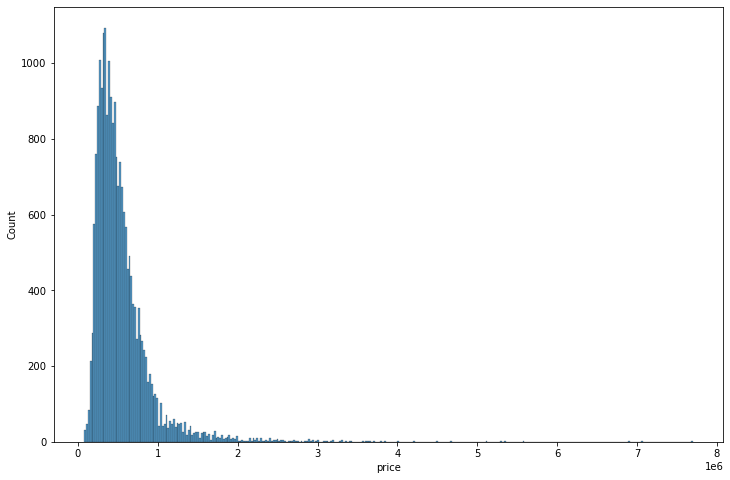

In [12]:
plt.figure(figsize=(12,8))
sns.histplot(df['price'])

Most of the houses fall between \\$0 and \\$1.5million. There do appear to be some (albeit very few) houses that are priced higher than $4 million.

<AxesSubplot:xlabel='waterfront', ylabel='price'>

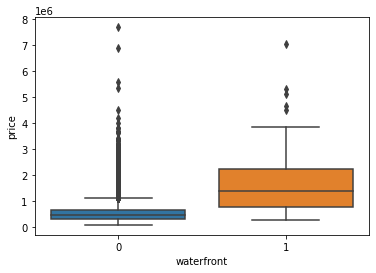

In [13]:
sns.boxplot(x='waterfront',y='price',data=df)

Houses on the waterfront are more likely to be more expensive than those that aren't.

## Feature engineering

In [14]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


I will drop the 'id' column as it does not have any useful information that we can use for our model.

In [15]:
df = df.drop('id',axis=1)

### Feature engineering using the date column

In its current format, the data column is not usable. I can however grab the month and year for each data point and use this in my model. 

First, converting the date column to the Pandas datetime format.

In [16]:
df['date'] = pd.to_datetime(df['date'])

Next, grabbing the month and the year from each date and putting them into new columns called 'month' and 'year' respectively. I will use a simple lambda function combined with the apply method.

In [17]:
df['month'] = df['date'].apply(lambda x:x.month)

In [18]:
df['year'] = df['date'].apply(lambda x:x.year)

Now I can drop the original date column as we won't be able to use this.

In [19]:
df = df.drop('date',axis=1)

I will also drop the zipcode column as this is technically a categorical column.

In [20]:
df = df.drop('zipcode',axis=1)

In [21]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,month,year
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650,10,2014
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,12,2014
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062,2,2015
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000,12,2014
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503,2,2015


Looking at the two columns 'yr_renovated' and 'sqft_basement', it appears that if the houses have not been renovated, or they do not have basements, the value for these is set to 0:

In [22]:
df['yr_renovated'].value_counts()

0       20683
2014       91
2013       37
2003       36
2000       35
        ...  
1934        1
1959        1
1951        1
1948        1
1944        1
Name: yr_renovated, Length: 70, dtype: int64

In [23]:
df['sqft_basement'].value_counts()

0       13110
600       221
700       218
500       214
800       206
        ...  
792         1
2590        1
935         1
2390        1
248         1
Name: sqft_basement, Length: 306, dtype: int64

We could feature engineer these columns so that if the houses were renovated or had a basement, they would have a value of 1 in those columns, and 0 otherwise. However, we don't have to do this because of the following:

For year renovated, houses that were renovated more recently would correlate with a higher price and so we can leave this column as it is.

Similar to square footage of basement, a larger basement would correlate with a higher price.

We can leave these two variables as continuous in this case.

## Train Test Split

I will split the data into a training set and a test set (70% of the data will be used in the training set).

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X = df.drop('price',axis=1)
y = df['price']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

## Scaling

I will do the scaling of the data after the split so I only fit to the training set to prevent data leakage to the test set. I will use MinMaxScaler from sklearn.preprocessing to scale the data.

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
scaler = MinMaxScaler()

In [30]:
X_train= scaler.fit_transform(X_train)

In [31]:
X_test = scaler.transform(X_test)

I do not fit to the test set because I don't want to assume prior information about the test set.

## Creating the model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

I have chosen the 'Adam' optimizer as it is computationally efficient and well suited for problems that are large in terms of data.

In [35]:
X_train.shape

(15117, 19)

Since the incoming data has 19 features, I think that 19 neurons are a good idea for the first layer of the model. I will use the Rectified Linear Unit (ReLU) activation function as it is easier to train and achieves good performance compared with other activation functions.

The final layer will have one neuron. This neuron will output the model's predicted price. Since this is a regression problem, I will chose mean squared error as the loss metric for this model.

In [36]:
model = Sequential()

model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(19,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

# Training

I will use the test data as validation data so that I can see how well the model is performing on the test data after each epoch. (One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters.)

Since this is large dataset, I will use a batch size of 64. This is a trade off between time taken to train the model and avoiding overfitting the model to the training data.

In [37]:
model.fit(x=X_train,y=y_train.values,
          validation_data=(X_test,y_test.values),
          batch_size=64,epochs=500)

Epoch 1/500
237/237 [==============================] - 3s 4ms/step - loss: 422484017152.0000 - val_loss: 430664908800.0000
Epoch 2/500
237/237 [==============================] - 1s 3ms/step - loss: 358337249280.0000 - val_loss: 243864190976.0000
Epoch 3/500
237/237 [==============================] - 1s 3ms/step - loss: 127523717120.0000 - val_loss: 104254808064.0000
Epoch 4/500
237/237 [==============================] - 1s 3ms/step - loss: 94514257920.0000 - val_loss: 100845486080.0000
Epoch 5/500
237/237 [==============================] - 1s 4ms/step - loss: 91304312832.0000 - val_loss: 97464967168.0000
Epoch 6/500
237/237 [==============================] - 1s 3ms/step - loss: 88125882368.0000 - val_loss: 93897424896.0000
Epoch 7/500
237/237 [==============================] - 1s 3ms/step - loss: 84721582080.0000 - val_loss: 90090397696.0000
Epoch 8/500
237/237 [==============================] - 1s 3ms/step - loss: 81055113216.0000 - val_loss: 86018613248.0000
Epoch 9/500
237/237 [====

237/237 [==============================] - 1s 4ms/step - loss: 33507604480.0000 - val_loss: 33666965504.0000
Epoch 69/500
237/237 [==============================] - 1s 4ms/step - loss: 33440944128.0000 - val_loss: 33529944064.0000
Epoch 70/500
237/237 [==============================] - 1s 4ms/step - loss: 33353631744.0000 - val_loss: 33427650560.0000
Epoch 71/500
237/237 [==============================] - 1s 3ms/step - loss: 33271228416.0000 - val_loss: 33332097024.0000
Epoch 72/500
237/237 [==============================] - 1s 4ms/step - loss: 33243916288.0000 - val_loss: 33218390016.0000
Epoch 73/500
237/237 [==============================] - 1s 4ms/step - loss: 33168717824.0000 - val_loss: 33249564672.0000
Epoch 74/500
237/237 [==============================] - 1s 3ms/step - loss: 33076652032.0000 - val_loss: 33059895296.0000
Epoch 75/500
237/237 [==============================] - 1s 3ms/step - loss: 33026168832.0000 - val_loss: 33029101568.0000
Epoch 76/500
237/237 [===============

Epoch 135/500
237/237 [==============================] - 1s 3ms/step - loss: 30864115712.0000 - val_loss: 30419726336.0000
Epoch 136/500
237/237 [==============================] - 1s 3ms/step - loss: 30838571008.0000 - val_loss: 30332913664.0000
Epoch 137/500
237/237 [==============================] - 1s 3ms/step - loss: 30791847936.0000 - val_loss: 30530738176.0000
Epoch 138/500
237/237 [==============================] - 1s 3ms/step - loss: 30825101312.0000 - val_loss: 30265851904.0000
Epoch 139/500
237/237 [==============================] - 1s 3ms/step - loss: 30800238592.0000 - val_loss: 30244528128.0000
Epoch 140/500
237/237 [==============================] - 1s 3ms/step - loss: 30733019136.0000 - val_loss: 30304798720.0000
Epoch 141/500
237/237 [==============================] - 1s 3ms/step - loss: 30733996032.0000 - val_loss: 30193393664.0000
Epoch 142/500
237/237 [==============================] - 1s 3ms/step - loss: 30714564608.0000 - val_loss: 30170198016.0000
Epoch 143/500
23

237/237 [==============================] - 1s 3ms/step - loss: 29469401088.0000 - val_loss: 28770613248.0000
Epoch 202/500
237/237 [==============================] - 1s 3ms/step - loss: 29424758784.0000 - val_loss: 28747919360.0000
Epoch 203/500
237/237 [==============================] - 1s 3ms/step - loss: 29420324864.0000 - val_loss: 28695957504.0000
Epoch 204/500
237/237 [==============================] - 1s 4ms/step - loss: 29387497472.0000 - val_loss: 28743800832.0000
Epoch 205/500
237/237 [==============================] - 1s 4ms/step - loss: 29383972864.0000 - val_loss: 28649670656.0000
Epoch 206/500
237/237 [==============================] - 1s 3ms/step - loss: 29375707136.0000 - val_loss: 28661776384.0000
Epoch 207/500
237/237 [==============================] - 1s 3ms/step - loss: 29345290240.0000 - val_loss: 28653645824.0000
Epoch 208/500
237/237 [==============================] - 1s 3ms/step - loss: 29293334528.0000 - val_loss: 28666558464.0000
Epoch 209/500
237/237 [=======

237/237 [==============================] - 1s 3ms/step - loss: 28036470784.0000 - val_loss: 27450404864.0000
Epoch 268/500
237/237 [==============================] - 1s 3ms/step - loss: 28064739328.0000 - val_loss: 27335995392.0000
Epoch 269/500
237/237 [==============================] - 1s 3ms/step - loss: 28035991552.0000 - val_loss: 27308621824.0000
Epoch 270/500
237/237 [==============================] - 1s 3ms/step - loss: 28056608768.0000 - val_loss: 27280674816.0000
Epoch 271/500
237/237 [==============================] - 1s 3ms/step - loss: 27985567744.0000 - val_loss: 27263326208.0000
Epoch 272/500
237/237 [==============================] - 1s 4ms/step - loss: 27942868992.0000 - val_loss: 27254970368.0000
Epoch 273/500
237/237 [==============================] - 1s 3ms/step - loss: 27967410176.0000 - val_loss: 27271852032.0000
Epoch 274/500
237/237 [==============================] - 1s 4ms/step - loss: 27927226368.0000 - val_loss: 27348697088.0000
Epoch 275/500
237/237 [=======

237/237 [==============================] - 1s 3ms/step - loss: 27047426048.0000 - val_loss: 26648139776.0000
Epoch 334/500
237/237 [==============================] - 1s 3ms/step - loss: 27099271168.0000 - val_loss: 26508029952.0000
Epoch 335/500
237/237 [==============================] - 1s 3ms/step - loss: 27047358464.0000 - val_loss: 26485295104.0000
Epoch 336/500
237/237 [==============================] - 1s 3ms/step - loss: 27020161024.0000 - val_loss: 26463932416.0000
Epoch 337/500
237/237 [==============================] - 1s 3ms/step - loss: 26960451584.0000 - val_loss: 26467350528.0000
Epoch 338/500
237/237 [==============================] - 1s 3ms/step - loss: 27030614016.0000 - val_loss: 26449252352.0000
Epoch 339/500
237/237 [==============================] - 1s 3ms/step - loss: 26972114944.0000 - val_loss: 26455973888.0000
Epoch 340/500
237/237 [==============================] - 1s 3ms/step - loss: 26946947072.0000 - val_loss: 26692923392.0000
Epoch 341/500
237/237 [=======

237/237 [==============================] - 1s 3ms/step - loss: 26344636416.0000 - val_loss: 26059522048.0000
Epoch 400/500
237/237 [==============================] - 1s 3ms/step - loss: 26348226560.0000 - val_loss: 26062893056.0000
Epoch 401/500
237/237 [==============================] - 1s 3ms/step - loss: 26310952960.0000 - val_loss: 26050887680.0000
Epoch 402/500
237/237 [==============================] - 1s 3ms/step - loss: 26309582848.0000 - val_loss: 26081296384.0000
Epoch 403/500
237/237 [==============================] - 1s 3ms/step - loss: 26263900160.0000 - val_loss: 26124259328.0000
Epoch 404/500
237/237 [==============================] - 1s 3ms/step - loss: 26280777728.0000 - val_loss: 26205720576.0000
Epoch 405/500
237/237 [==============================] - 1s 3ms/step - loss: 26319861760.0000 - val_loss: 26067372032.0000
Epoch 406/500
237/237 [==============================] - 1s 3ms/step - loss: 26235207680.0000 - val_loss: 26020974592.0000
Epoch 407/500
237/237 [=======

237/237 [==============================] - 1s 3ms/step - loss: 25778538496.0000 - val_loss: 26029017088.0000
Epoch 466/500
237/237 [==============================] - 1s 4ms/step - loss: 25783631872.0000 - val_loss: 25963796480.0000
Epoch 467/500
237/237 [==============================] - 1s 4ms/step - loss: 25769562112.0000 - val_loss: 25992976384.0000
Epoch 468/500
237/237 [==============================] - 1s 4ms/step - loss: 25764524032.0000 - val_loss: 26085761024.0000
Epoch 469/500
237/237 [==============================] - 1s 3ms/step - loss: 25783300096.0000 - val_loss: 26062030848.0000
Epoch 470/500
237/237 [==============================] - 1s 3ms/step - loss: 25728792576.0000 - val_loss: 26007322624.0000
Epoch 471/500
237/237 [==============================] - 1s 3ms/step - loss: 25822285824.0000 - val_loss: 25995329536.0000
Epoch 472/500
237/237 [==============================] - 1s 4ms/step - loss: 25747605504.0000 - val_loss: 25998157824.0000
Epoch 473/500
237/237 [=======

I will look at the history of the model's loss and validation loss. Plotting this shows:

<AxesSubplot:>

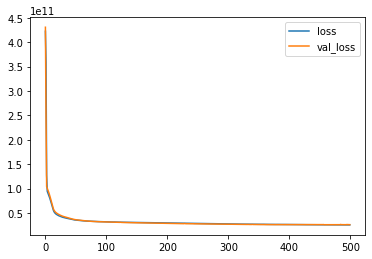

In [39]:
pd.DataFrame(model.history.history).plot()

Both the loss and validation loss drop off at the same rate. There are no signs of overfitting as the val_loss line does not spike upwards or move erratically as the model training. Had there been signs of overfitting, it may have been necessary to experiment with adding in early stopping calls or having dropout layers in the model.

## Predicting using the model

In [41]:
predictions = model.predict(X_test)

## Evaluation of model on Test Data

I will use mean absolute error and explained variance score from Sklearn to evaluate how well my model works.

In [40]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [42]:
mean_absolute_error(y_test,predictions)

99760.28662591628

The average absolute error across all predictions is 99760. Comparing this to the average house price in our dataset:

In [44]:
df['price'].mean()

540296.5735055795

In [43]:
explained_variance_score(y_test,predictions)

0.8160857796230987

The average absolute error is quite high, especially considering mean house prices. The model does not appear to be great at correctly predicting house prices.

Plotting predicted house prices against actual house prices:

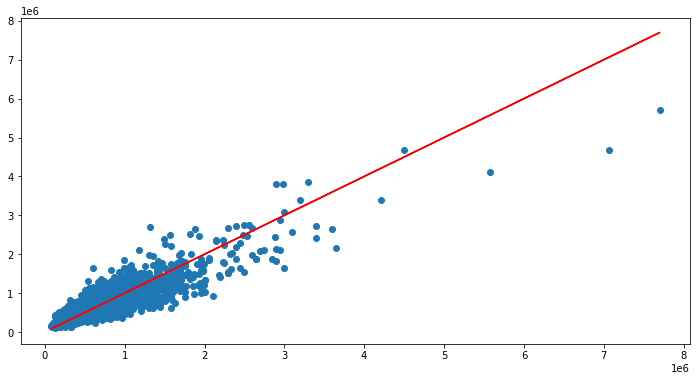

In [48]:
plt.figure(figsize=(12,6))
plt.scatter(y_test,predictions)
plt.plot(y_test,y_test,'r')

The red line shows where points would lie if our model was perfect at predicting house prices. I can see that between \\$0 and \\$2 million, the model does seem to fare much better at predicting house prices. 